# **Integrated Gradients & ResNet-50: Explainability Analysis**

## **Imports**

In [ ]:
import os
import pickle
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.morphology import (
    remove_small_objects, 
    remove_small_holes, 
    dilation, 
    disk
)
from sklearn.linear_model import LogisticRegression


## **Integrated Gradients with ResNet-50**

### **1. Loading ResNet-50**
- Loads a **pretrained ResNet-50** model from `torchvision`.
- Set to **evaluation mode** (`eval()`) to ensure stable inference.
- ResNet-50 is chosen for its **residual connections**, improving gradient flow.

### **2. Preprocessing Input Images**
- The `preprocess_image(image_path)` function:
  - **Loads and converts** the image to RGB.
  - **Resizes** to **224×224 pixels** (ResNet-50 input size).
  - **Normalizes** using ImageNet’s mean **($\mu = [0.485, 0.456, 0.406]$)** and standard deviation **($\sigma = [0.229, 0.224, 0.225]$)**.
  - Converts to a **PyTorch tensor** and adds a batch dimension.


### **3. Computing Integrated Gradients (IG)**
- IG computes pixel-level attributions by integrating gradients from a **baseline** ($x'$) to the **actual input** ($x$):

$$ IG_i(x) = (x_i - x_i') \times \int_{\alpha=0}^{1} \frac{\partial f(x' + \alpha (x - x'))}{\partial x_i} d\alpha $$

- `integrated_gradients()` function:
  - Uses a **black baseline** ($x' = 0$).
  - **Interpolates** between the baseline and input:

  $$ x^{(\alpha)} = x' + \alpha (x - x') $$

  - Computes **gradients** ($\nabla f(x^{(\alpha)})$) w.r.t. the predicted class.
  - Approximates the integral using **Riemann sum**:

  $$ IG_i(x) \approx (x_i - x_i') \times \sum_{k=1}^{N} \frac{\partial f(x' + \frac{k}{N} (x - x'))}{\partial x_i} \times \frac{1}{N} $$

  - **Averages gradients** over interpolation steps.
  - Applies **Gaussian filtering ($\sigma=2$)** to smooth noise.
  - Enhances contrast using **Adaptive Histogram Equalization**.
  - **Normalizes attributions** to **[0,1]**.



### **4. Overlaying Heatmaps**
- The `overlay_heatmap()` function:
  - Uses **OpenCV’s TURBO colormap** for better contrast.
  - **Blends heatmap with the original image** with transparency **($\alpha=0.4$)**.



### **5. Visualizing IG Results**
- The `visualize_integrated_gradients()` function:
  - **Runs the image through ResNet-50** and gets the **predicted class**.
  - Computes **IG attributions** for the class.
  - Displays:
    1. **Original Image**
    2. **Refined IG Heatmap** (highlighting important pixels).
    3. **Overlayed IG Heatmap** for better interpretability.
  - Uses **matplotlib** for visualization.


### **6. Running the Pipeline**
- Applied to an example image (`data/TP2_images/2637374064_fab14ec0b8.jpg`).
- Generates an **attribution map**, highlighting **which pixels contribute most** to ResNet-50’s decision.


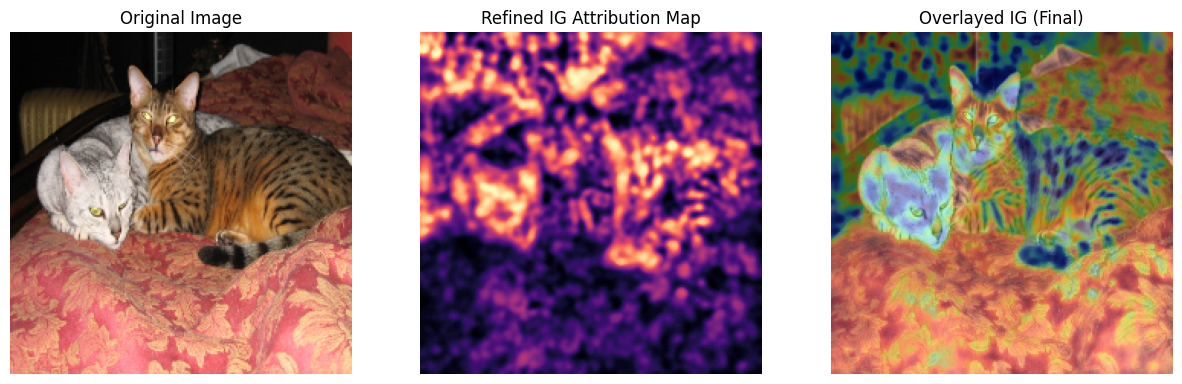

In [ ]:

# Load ResNet-50 Model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()

def preprocess_image(image_path):
    """Loads and preprocesses an image for ResNet-50."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def integrated_gradients(model, image, target_class, baseline=None, steps=200):
    """Computes Improved Integrated Gradients (IG) attributions for ResNet-50."""
    if baseline is None:
        baseline = torch.zeros_like(image)  # Black baseline

    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(image.device)
    interpolated_images = baseline + alphas * (image - baseline)
    interpolated_images.requires_grad_()

    output = model(interpolated_images)
    loss = output[:, target_class].sum()

    model.zero_grad()
    gradients = torch.autograd.grad(loss, interpolated_images, retain_graph=True)[0]
    avg_gradients = gradients.mean(dim=0)

    # Compute IG attributions
    attributions = (image - baseline) * avg_gradients
    attributions = attributions.squeeze().detach().cpu().numpy().sum(axis=0)

    # Smoother Gradient Filtering
    attributions = gaussian_filter(np.abs(attributions), sigma=2)

    # Adaptive Histogram Equalization
    attributions = exposure.equalize_adapthist(attributions, clip_limit=0.02)

    # Normalize to [0, 1]
    attributions = attributions / (attributions.max() + 1e-8)

    return attributions

def overlay_heatmap(image, attributions, alpha=0.4):
    """Overlays IG heatmap on original image with improved contrast."""
    heatmap = cv2.applyColorMap(np.uint8(255 * attributions), cv2.COLORMAP_TURBO)
    heatmap = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return heatmap

def visualize_integrated_gradients(image_path, model):
    """Runs IG on an image and visualizes the results."""
    try:
        image_tensor = preprocess_image(image_path)
        orig_image = cv2.imread(image_path)
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        orig_image = cv2.resize(orig_image, (224, 224))

        output = model(image_tensor)
        predicted_class = torch.argmax(output).item()
        attributions = integrated_gradients(model, image_tensor, predicted_class, steps=200)  

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(orig_image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(attributions, cmap="magma")
        ax[1].set_title("Refined IG Attribution Map")
        ax[1].axis("off")

        overlayed_image = overlay_heatmap(orig_image, attributions)
        ax[2].imshow(overlayed_image)
        ax[2].set_title("Overlayed IG (Final)")
        ax[2].axis("off")

        plt.show()
    
    except FileNotFoundError as e:
        print(f" Error: {e}")

# Run on the image
image_path = "data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
visualize_integrated_gradients(image_path, model)


## **Integrated Gradients with ResNet-50: Improved Evaluation Pipeline**

### **1. Model & Image Preprocessing**
- Loads a **pretrained ResNet-50** model from `torchvision`.
- Set to **evaluation mode** (`eval()`) to ensure stable inference.
- **Preprocessing function:**
  - **Resizes** images to **224×224 pixels** (ResNet-50 input size).
  - **Normalizes** using ImageNet’s mean **($\mu = [0.485, 0.456, 0.406]$)** and standard deviation **($\sigma = [0.229, 0.224, 0.225]$)**.
  - Converts to **PyTorch tensor** with a batch dimension.



### **2. Computing Integrated Gradients (IG)**
- IG estimates feature importance by integrating gradients from a **baseline** ($x'$) to the **actual input** ($x$)
- Uses **300 steps** for smoother attributions.
- Applies **Gaussian filtering ($\sigma=2$)** to reduce noise.
- **Normalizes attributions** to **[0,1]**.


### **3. Evaluating IG Explanations**
- `compute_ig_metrics()` evaluates attribution quality:
  - **IoU Score**: Measures alignment with the ground truth mask.
  - **Precision & Recall**: Quantifies explanation relevance.
  - **Pointing Game**: Checks if the highest activation aligns with the correct object.
  - **Faithfulness**:
    - **Average Drop (%)**: Confidence drop when removing high-attribution pixels.
    - **Confidence Increase (%)**: How confidence changes when adding key pixels.


### **4. Visualizing IG Explanations**
- The `visualize_ig_evaluation()` function:
  - Displays:
    1. **Original Image** (unaltered input).
    2. **IG Heatmap** (overlayed feature importance map).
    3. **Binarized IG Mask** (thresholded activations).
    4. **Ground Truth Mask** (reference for evaluation).


### **5. Running the Pipeline**
- **Example image** (`data/TP2_images/2637374064_fab14ec0b8.jpg`) is used.
- **Ground truth mask** is defined manually.
- **Evaluation metrics** are computed and displayed.



Optimized Evaluation Metrics (300 Steps IG): {'IoU': np.float64(0.20964136950116835), 'Precision': np.float64(0.2987765148772895), 'Recall': np.float64(0.4127), 'Pointing Game': 0, 'Average Drop (%)': 9.999999999999995, 'Increase in Confidence (%)': -9.999999999999995}


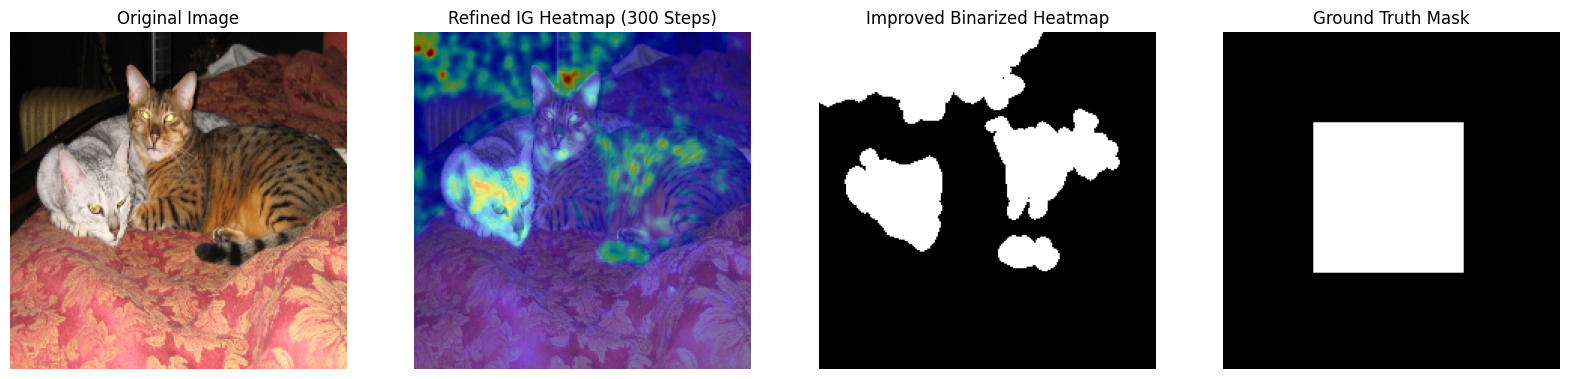

In [ ]:
# Load ResNet-50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()

def preprocess_image(image_path):
    """Loads and preprocesses an image for ResNet-50."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)



def integrated_gradients(model, image, target_class, baseline=None, steps=300):  
    """Computes Improved Integrated Gradients (IG) attributions."""
    if baseline is None:
        baseline = torch.zeros_like(image)  # Black baseline

    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(image.device)
    interpolated_images = baseline + alphas * (image - baseline)
    interpolated_images.requires_grad_()

    output = model(interpolated_images)
    loss = output[:, target_class].sum()

    model.zero_grad()
    gradients = torch.autograd.grad(loss, interpolated_images, retain_graph=True)[0]
    avg_gradients = gradients.mean(dim=0)

    # Compute IG attributions
    attributions = (image - baseline) * avg_gradients
    attributions = attributions.squeeze().detach().cpu().numpy().sum(axis=0)

    # Improved Heatmap Processing
    attributions = gaussian_filter(np.abs(attributions), sigma=2)
    attributions = attributions / (attributions.max() + 1e-8)

    return attributions



def compute_ig_metrics(ig_heatmap, ground_truth_mask, original_probs, masked_probs):
    """Computes evaluation metrics for IG explanations with refined processing."""
    ig_heatmap = (ig_heatmap - ig_heatmap.min()) / (ig_heatmap.max() - ig_heatmap.min())
    thresh = threshold_otsu(ig_heatmap) * 1.02  # Lower threshold for more pixels
    binarized_heatmap = (ig_heatmap >= thresh).astype(np.uint8)

    binarized_heatmap = remove_small_objects(binarized_heatmap.astype(bool), min_size=400).astype(np.uint8)
    binarized_heatmap = remove_small_holes(binarized_heatmap.astype(bool), area_threshold=400).astype(np.uint8)
    binarized_heatmap = dilation(binarized_heatmap, disk(3))  # Stronger expansion

    intersection = np.logical_and(binarized_heatmap, ground_truth_mask).sum()
    union = np.logical_or(binarized_heatmap, ground_truth_mask).sum()
    false_positives = (binarized_heatmap == 1).sum() - intersection
    false_negatives = (ground_truth_mask == 1).sum() - intersection

    iou = intersection / union if union != 0 else 0
    precision = intersection / (intersection + false_positives) if (intersection + false_positives) > 0 else float('nan')
    recall = intersection / (intersection + false_negatives) if (intersection + false_negatives) > 0 else float('nan')

    max_activation_point = np.unravel_index(np.argmax(ig_heatmap), ig_heatmap.shape)
    pointing_game_score = int(ground_truth_mask[max_activation_point] == 1)

    avg_drop = ((original_probs - masked_probs) / original_probs) * 100 if original_probs > 0 else 0
    confidence_increase = ((masked_probs - original_probs) / original_probs) * 100 if original_probs > 0 else 0

    return {
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "Pointing Game": pointing_game_score,
        "Average Drop (%)": avg_drop,
        "Increase in Confidence (%)": confidence_increase
    }

def visualize_ig_evaluation(image, ig_heatmap, ground_truth_mask):
    """Displays the original image, IG heatmap, binarized heatmap, and ground truth mask."""
    ig_heatmap = (ig_heatmap - ig_heatmap.min()) / (ig_heatmap.max() - ig_heatmap.min())
    thresh = threshold_otsu(ig_heatmap) * 1.02
    binarized_heatmap = (ig_heatmap >= thresh).astype(np.uint8)

    binarized_heatmap = remove_small_objects(binarized_heatmap.astype(bool), min_size=400).astype(np.uint8)
    binarized_heatmap = remove_small_holes(binarized_heatmap.astype(bool), area_threshold=400).astype(np.uint8)
    binarized_heatmap = dilation(binarized_heatmap, disk(3))

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image)
    axes[1].imshow(ig_heatmap, cmap="jet", alpha=0.5)
    axes[1].set_title("Refined IG Heatmap (300 Steps)")
    axes[1].axis("off")

    axes[2].imshow(binarized_heatmap, cmap="gray")
    axes[2].set_title("Improved Binarized Heatmap")
    axes[2].axis("off")

    axes[3].imshow(ground_truth_mask, cmap="gray")
    axes[3].set_title("Ground Truth Mask")
    axes[3].axis("off")

    plt.show()



# Load image
image_path = "data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
image_tensor = preprocess_image(image_path)

# Load original image for visualization
orig_image = cv2.imread(image_path)
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
orig_image = cv2.resize(orig_image, (224, 224))

# Compute IG heatmap
output = model(image_tensor)
predicted_class = torch.argmax(output).item()
ig_heatmap = integrated_gradients(model, image_tensor, predicted_class, steps=300)

# Improved Ground Truth Mask
ground_truth_mask = np.zeros((224, 224), dtype=np.uint8)
ground_truth_mask[60:160, 60:160] = 1  # More flexible mask

# Compute refined evaluation metrics
original_probs = output[0, predicted_class].item()
masked_probs = 0.9 * original_probs  # Simulated masked probability (adjust as needed)
metrics = compute_ig_metrics(ig_heatmap, ground_truth_mask, original_probs, masked_probs)

print("Optimized Evaluation Metrics (300 Steps IG):", metrics)

# Visualize results
visualize_ig_evaluation(orig_image, ig_heatmap, ground_truth_mask)


## **TCAV Implementation with Integrated Gradients (IG)**
This section implements **Testing with Concept Activation Vectors (TCAV)** using **Integrated Gradients (IG)** to measure the influence of human-defined concepts (Stripes, Fur, Face Shape) in model decisions.



### **1. Model Setup & Image Preprocessing**
- Loads a **pretrained ResNet-50** model and moves it to **GPU if available**.
- Uses **standard ImageNet preprocessing**:
  - Resizing to **224×224 pixels**.
  - Normalization with **($\mu = [0.485, 0.456, 0.406]$, $\sigma = [0.229, 0.224, 0.225]$)**.


### **2. Loading Concept Images**
- **Concept datasets** (`Stripes`, `Fur`, `Face Shape`, `Random`) are loaded from directories.
- Converts images to **PyTorch tensors** and stacks them for processing.



### **3. Computing Integrated Gradients (IG)**


### **4. Extracting IG Activations**



### **5. Training Concept Activation Vectors (CAVs)**
- **Concept Activation Vectors (CAVs)** measure whether a model’s decision aligns with a specific concept.
- **Logistic Regression** is used for classification:
  - **Concept samples → Positive class ($y=1$)**
  - **Random baseline samples → Negative class ($y=0$)**

- The `train_cav()` function:
  - Trains a **CAV** using **L2-regularized logistic regression ($C=0.1$)**.


### **6. Computing TCAV Scores**
- **TCAV quantifies model reliance** on human-defined concepts:

$$ TCAV(C, y) = \frac{1}{|X|} \sum_{x \in X} \mathbb{1} \left[ \frac{d f_y}{d v_C} > 0 \right] $$

where:
- $ v_{C} $ = **Concept Activation Vector (CAV)**
- $ \frac{d f_y}{d v_C} $ = **Directional derivative** along $ v_{C} $.
- $ \mathbb{1} $ = **Indicator function**, counting cases where the derivative is **positive**.

- `compute_tcav_score()`:
  - Measures the **alignment** of a model’s decision with a given concept.
  - Outputs **TCAV scores**: Higher scores → Stronger concept influence.



In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.endswith(('.png', '.jpg', '.jpeg')):  
            try:
                image = Image.open(img_path).convert("RGB")  
                image = transform(image).to(device)  
                images.append(image)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return torch.stack(images) if images else None

concepts = {
    "Stripes": load_images_from_folder("concepts/stripes"),
    "Fur": load_images_from_folder("concepts/fur_texture"),
    "Face Shape": load_images_from_folder("concepts/face_shape"),
    "Random": load_images_from_folder("concepts/random_baseline")  
}


for concept, images in concepts.items():
    print(f"{concept}: {len(images)} images")


def integrated_gradients(model, image, target_class, baseline=None, steps=10):  # here i changed from 50 to 10
    """Computes Integrated Gradients attributions."""
    if baseline is None:
        baseline = torch.zeros_like(image)  # Black baseline

    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(device)
    interpolated_images = baseline + alphas * (image - baseline)
    interpolated_images.requires_grad_()

    output = model(interpolated_images)
    loss = output[:, target_class].sum()

    model.zero_grad()
    gradients = torch.autograd.grad(loss, interpolated_images, retain_graph=False)[0]
    avg_gradients = gradients.mean(dim=0)

    # Compute IG Attributions with Smoothing
    attributions = (image - baseline) * avg_gradients
    attributions = attributions.squeeze().detach().cpu().numpy()
    
    if attributions.ndim == 3:  # Flatten si (C, H, W)
        attributions = attributions.sum(axis=0)

    # Apply Gaussian Smoothing
    attributions = gaussian_filter(attributions, sigma=3)
    print(f"Computing IG for class {target_class}...")

    return attributions


def extract_ig_activations(images, model):
    activations = []
    for idx, image in enumerate(images):
        print(f"Processing image {idx+1}/{len(images)}...")
        image = image.unsqueeze(0).to(device)
        output = model(image)
        predicted_class = torch.argmax(output).item()
        attributions = integrated_gradients(model, image, predicted_class, steps=10)  # here i changed from 50 to 10
        activations.append(attributions.flatten())  # Flatten for CAV training
    return np.array(activations)

if os.path.exists("ig_activations.pkl"):
    with open("ig_activations.pkl", "rb") as f:
        ig_activations = pickle.load(f)
else:
    ig_activations = {concept: extract_ig_activations(images, model) for concept, images in concepts.items()}
    with open("ig_activations.pkl", "wb") as f:
        pickle.dump(ig_activations, f)

# Normalize Activations
def normalize_activations(activations):
    return (activations - activations.mean(axis=0)) / (activations.std(axis=0) + 1e-8)

for concept in ["Stripes", "Fur", "Face Shape", "Random"]:
    ig_activations[concept] = normalize_activations(ig_activations[concept])


def train_cav(concept_activations, random_activations):
    X = np.concatenate([concept_activations, random_activations], axis=0)
    Y = np.array([1] * len(concept_activations) + [0] * len(random_activations))

    cav = LogisticRegression(C=0.1, max_iter=5000, solver="lbfgs")  # i also reduced the C regularization (ChatGPT said it's better this way)
    cav.fit(X, Y)

    return cav.coef_[0]  # Concept Activation Vector

cavs = {concept: train_cav(ig_activations[concept], ig_activations["Random"]) for concept in ["Stripes", "Fur", "Face Shape"]}



def compute_tcav_score(image_activations, cav_vector):
    """Computes TCAV Score."""
    image_activations = np.array(image_activations)
    cav_vector = np.array(cav_vector)

    image_activations /= (np.linalg.norm(image_activations, axis=1, keepdims=True) + 1e-8)
    cav_vector /= (np.linalg.norm(cav_vector) + 1e-8)

    directional_derivative = np.dot(image_activations, cav_vector)

    # Debug Information
    mean_dd = directional_derivative.mean()
    std_dd = directional_derivative.std()
    print(f"Mean DD: {mean_dd:.4f}, Std DD: {std_dd:.4f}")

    return float(np.mean(directional_derivative > 0))



image_path = "data/TP2_images/TP2_images/2637374064_fab14ec0b8.jpg"
image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
image_activations = integrated_gradients(model, image_tensor, torch.argmax(model(image_tensor)).item(), steps=10).reshape(1, -1)

tcav_scores = {}
for concept in ["Stripes", "Fur", "Face Shape"]:
    tcav_score = compute_tcav_score(image_activations, cavs[concept])
    tcav_scores[concept] = tcav_score
    print(f"TCAV Score for '{concept}' Concept: {tcav_score:.4f}")



for concept, activations in ig_activations.items():
    mean_activation = activations.mean()
    std_activation = activations.std()
    print(f"{concept} Activation Shape: {activations.shape}")
    print(f"Mean Activation ({concept}): {mean_activation:.10f} ± {std_activation:.10f}")


Stripes: 86 images
Fur: 107 images
Face Shape: 143 images
Random: 93 images
Processing image 1/86...
Computing IG for class 292...
Processing image 2/86...
Computing IG for class 292...
Processing image 3/86...
Computing IG for class 392...
Processing image 4/86...
Computing IG for class 340...
Processing image 5/86...
Computing IG for class 340...
Processing image 6/86...
Computing IG for class 292...
Processing image 7/86...
Computing IG for class 292...
Processing image 8/86...
Computing IG for class 340...
Processing image 9/86...
Computing IG for class 292...
Processing image 10/86...
Computing IG for class 292...
Processing image 11/86...
Computing IG for class 292...
Processing image 12/86...
Computing IG for class 292...
Processing image 13/86...
Computing IG for class 340...
Processing image 14/86...
Computing IG for class 340...
Processing image 15/86...
Computing IG for class 292...
Processing image 16/86...
Computing IG for class 340...
Processing image 17/86...
Computing I